### Phase-based encoding in pairwise neural interactions

In [1]:
import os

In [2]:
import sys

sys.path.insert(1, os.path.join("/", *os.getcwd().split("/")[:-1]))

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from tqdm import tqdm

from src.models import simulate_kuramoto

In [4]:
dt = 1e-4  # Sample frequency

fs = 1 / dt  # Integration time-step
f = 40  # Natural frequency
beta = 3.5  # Noise variance
A = np.array([[0, 1], [0, 0]])  # Adjacency matrix
ntrials = 200
time = np.arange(-4, 4, dt)  # Time array
T = time.shape[0]

In [5]:
s = 30 / (2 * np.pi * f)

time_start = 0
time_end = 1
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling[ind] = gaussian

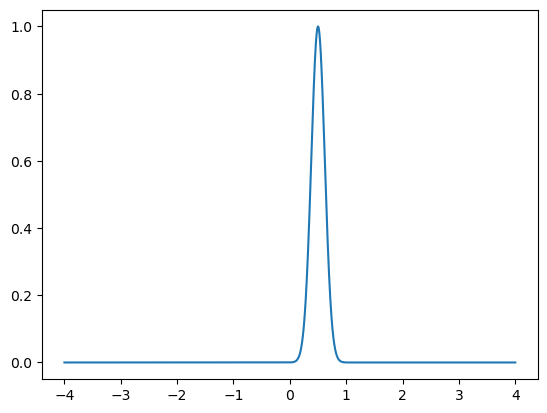

In [6]:
plt.plot(time, coupling)

In [7]:
data = []
for trial in tqdm(range(ntrials)):
    data += [
        simulate_kuramoto(
            10 * A,
            coupling * trial * 100 / ntrials,
            f,
            fs,
            beta,
            T,
            seed=trial * 25703989,
        )
    ]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:29<00:00,  6.87it/s]


In [8]:
data = np.stack(data)[..., (time >= -1) * (time <= 2)]

(-0.2, 0.2)

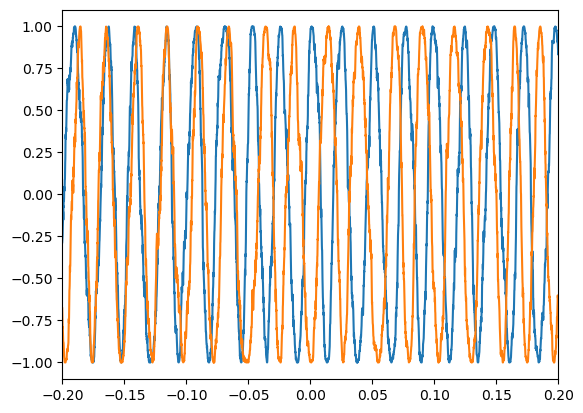

In [9]:
plt.plot(time[(time >= -1) * (time <= 2)], data[-1].real.T)
plt.xlim(-0.2, 0.2)

In [61]:
freqs = np.linspace(0.1, 80, 50)
W = tfr_array_multitaper(data, fs, freqs, n_cycles=freqs, decim=20, n_jobs=1)

In [63]:
Sxy = (W[:, 0] * np.conj(W[:, 1])).mean((0, 2))
Sxx = (W[:, 0] * np.conj(W[:, 0])).mean((0, 2))
Syy = (W[:, 1] * np.conj(W[:, 1])).mean((0, 2))

coh = np.abs(Sxy) ** 2 / (Sxx * Syy)

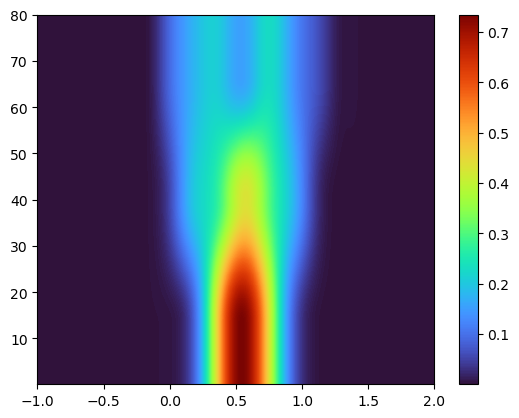

In [64]:
plt.imshow(
    coh.real, aspect="auto", origin="lower", cmap="turbo", extent=[-1, 2, 0.1, 80]
)
plt.colorbar()

In [65]:
mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

In [51]:
z.shape

(200, 50, 1500)

In [52]:
z = (W[:, 0] * np.conj(W[:, 1]))

dphi = np.angle(z)

labels = np.tile(
    np.expand_dims(np.arange(ntrials) * 100 / ntrials, (1, 2)), (z.shape[1], z.shape[2])
)

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

In [57]:
MI_PHI = mi_fcn_time_frequency(z[None], labels[None], False, True)

In [58]:
MI_PHI.shape

(50, 1500)

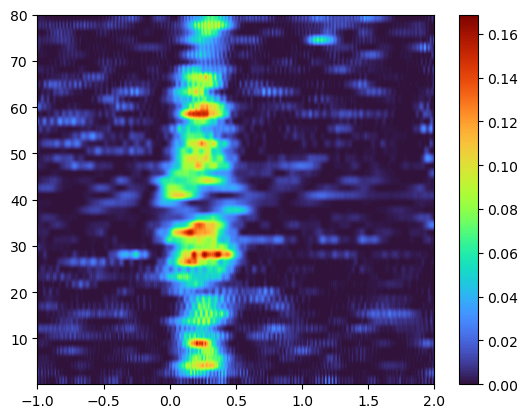

In [60]:
plt.imshow(MI_PHI, aspect="auto", origin="lower", cmap="turbo", extent=[-1, 2, 0.1, 80])
plt.colorbar()

In [ ]:
"""
n_boots = 500

MI_surr = []

for i in tqdm(range(n_boots)):

    stim_perm = np.random.permutation(np.arange(100) * 30 / 100)
    labels_perm = np.tile(np.expand_dims(stim_perm, (1, 2)), (W.shape[2], W.shape[3]))

    MI_surr += [mi_fcn_time_frequency(dphi[None], labels_perm[None], True, True)]
""";